## BIOINFORMATICS THESIS: MULTIMODAL NEURAL NETWORK

# CELL LINE: A549

In [1]:
import pandas as pd 
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, OrderedDict
import pickle

import sqlite3
from sqlalchemy import create_engine

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS

In [3]:
from BIOINF_tesi.data_pipe import Load_Create_Task
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline

In [4]:
from BIOINF_tesi.models import FFNN, CNN, CNN_LSTM
from BIOINF_tesi.models.utils import fit, Param_Search, Kfold_CV

In [5]:
with open ('results_dict.pickle', 'rb') as fin:
    results_dict = pickle.load(fin)
    results_dict = defaultdict(lambda: defaultdict(dict), results_dict)

In [6]:
from BIOINF_tesi.visual import print_content_results_dict

In [11]:
print_content_results_dict('EmbraceNetMultimodal_augm')

A549

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


GM12878

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


H1

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P

active_EP_vs_inactive_rest


HEK293

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P

active_EP_vs_inactive_rest


HEPG2

active_E_vs_inactive_E
EmbraceNetMultimodal_augm



---

In [9]:
from BIOINF_tesi.visual import get_average_AUPRC_df

df = get_average_AUPRC_df(models=['FFNN','CNN','EmbraceNetMultimodal','ConcatNetMultimodal',
                                 'EmbraceNetMultimodal_augm'])

for model in df.keys():
    print(model)
    display(df[model])

FFNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.12792,0.24045,0.6767,0.57161,0.20654
GM12878,0.41504,0.34183,0.84293,0.57068,0.33679
H1,0.10707,0.25076,0.55682,0.57934,0.20899
HEK293,0.16061,0.31227,0.81008,0.57137,0.24144
HEPG2,0.28586,0.35415,0.77376,0.59477,0.31254
K562,0.16987,0.35191,0.80136,0.57487,0.21239
MCF7,0.13679,0.32739,0.76352,0.57257,0.21045


CNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.06011,0.19374,0.65774,0.58422,0.14678
GM12878,0.20147,0.23723,0.78504,0.55978,0.20721
H1,0.08377,0.20219,0.33909,0.5997,0.19009
HEK293,0.11423,0.24028,0.60146,0.45543,0.20859
HEPG2,0.12415,0.24769,0.68355,0.57477,0.19717
K562,0.09604,0.24245,0.64967,0.56412,0.16921
MCF7,0.08775,0.19941,0.55164,0.45291,0.17418


EmbraceNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.09301,0.18169,0.68973,0.57851,0.15695
GM12878,0.39003,0.23404,0.74794,0.56198,0.27255
H1,0.08783,0.29423,0.40921,0.58471,0.23451
HEK293,0.12506,0.24603,0.78331,0.58511,0.20273
HEPG2,0.12313,0.28192,0.57915,0.57384,0.17412
K562,0.10981,0.33587,0.76434,0.57377,0.17803
MCF7,0.08383,0.25756,0.54421,0.59234,0.17586


ConcatNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.07598,0.21349,0.69375,0.59152,0.17485
GM12878,0.34071,0.24199,0.73271,0.54756,0.32124
H1,0.0948,0.2321,0.33734,0.58151,0.22755
HEK293,0.12869,0.24035,0.74639,0.58561,0.17691
HEPG2,0.18464,0.2446,0.6616,0.59477,0.25679
K562,0.11477,0.31197,0.63634,0.59153,0.22964
MCF7,0.08323,0.2504,0.76525,0.59242,0.24137


EmbraceNetMultimodal_augm


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.09038,0.20377,0.67142,0.58066,0.20766
GM12878,0.26883,0.27028,0.67502,0.56361,0.31847
H1,0.15266,0.24426,0.29897,NaN,NaN
HEK293,0.12528,0.23461,0.8063,NaN,NaN
HEPG2,NaN,NaN,NaN,NaN,NaN
K562,NaN,NaN,NaN,NaN,NaN
MCF7,NaN,NaN,NaN,NaN,NaN


---

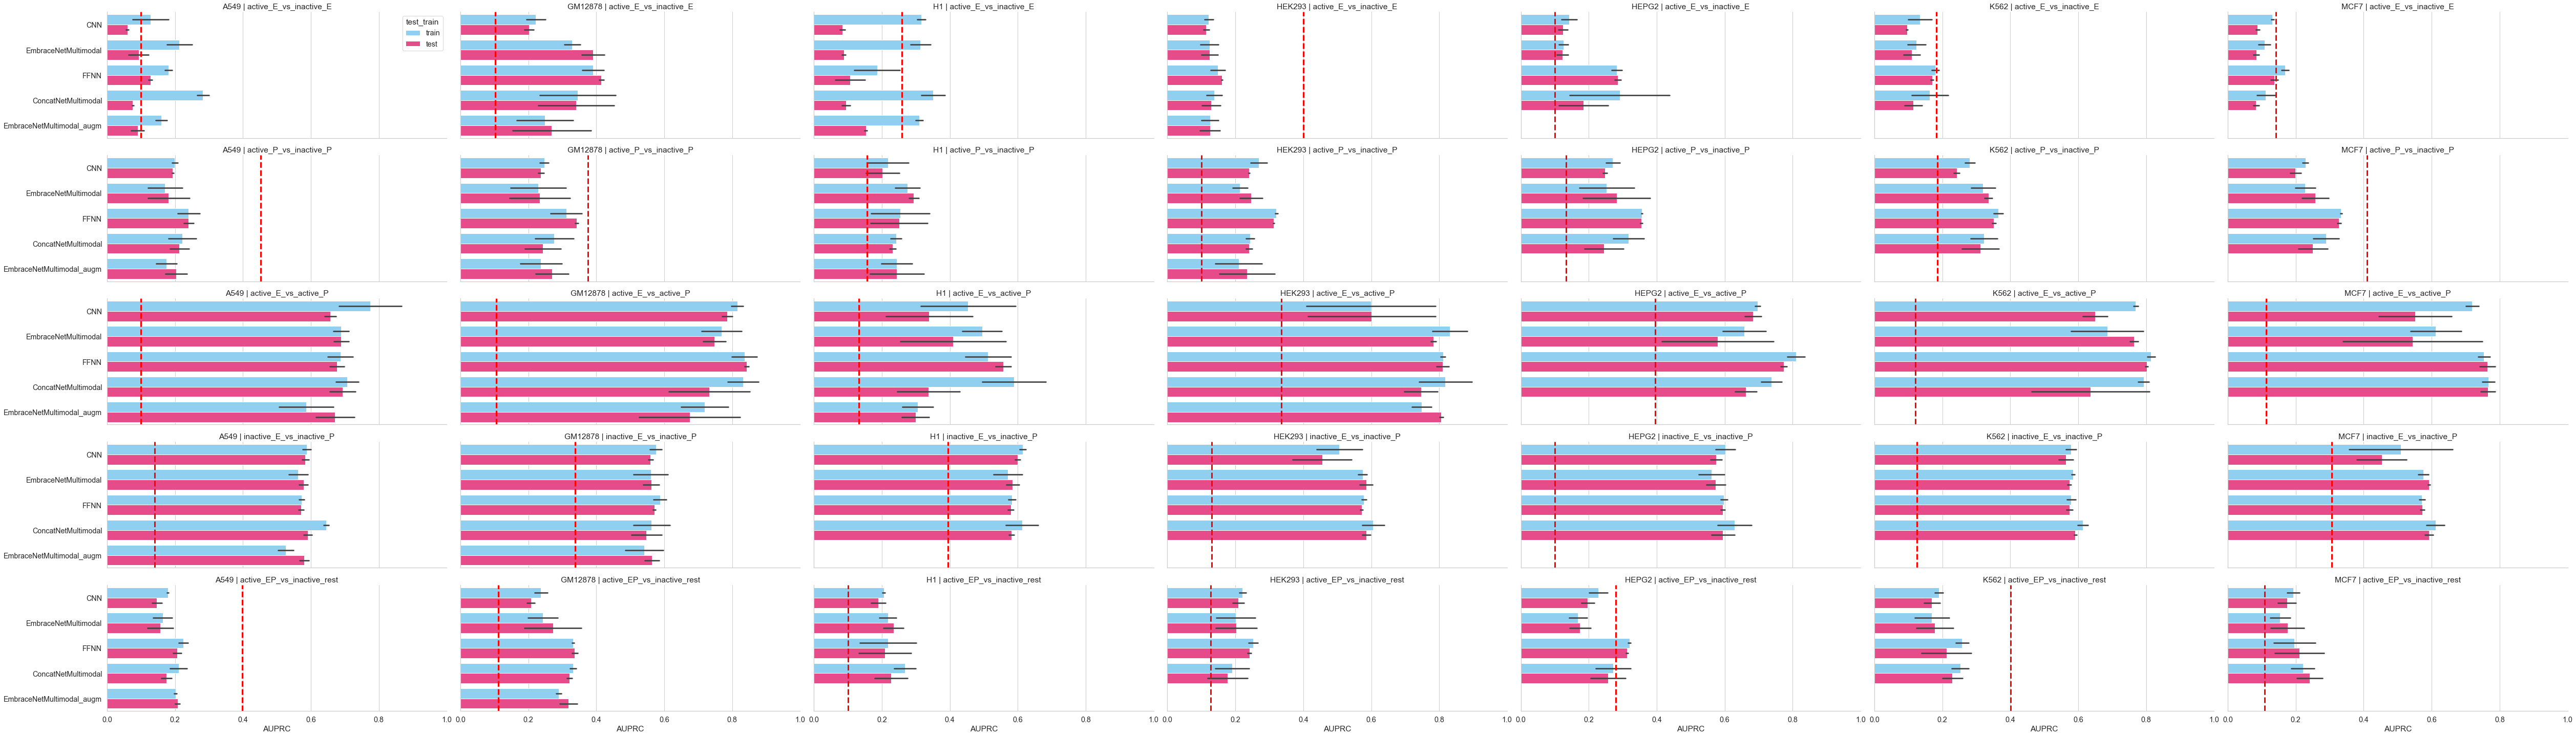

In [10]:
from BIOINF_tesi.visual import plot_scores
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS
plot_scores(cells=CELL_LINES, models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], palette=0)

---

In [7]:
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline
from BIOINF_tesi.models import EmbraceNetMultimodal, ConcatNetMultimodal
from BIOINF_tesi.models.utils import Kfold_CV_Multimodal
cell_line = CELL_LINES[2]
cell_line
task = TASKS[0]
pipe_data_load = Build_DataLoader_Pipeline(path_name=f'{task}.pickle')
model=EmbraceNetMultimodal

Data Preprocessing Done!


In [8]:
kf_CV = Kfold_CV_Multimodal()

kf_CV(build_dataloader_pipeline = pipe_data_load,
                num_epochs = 100,
                n_folds=3,
                cell_line=cell_line,
                augmentation=True,
                model = model,
                device = device,
                task=task,
                sampler = 'TPE',
                study_name = f'{cell_line}_{task}_{model.__name__}',
                test_model_path = f'{cell_line}_{task}_{model.__name__}_TEST')

>>> ITERATION N. 1

===============> HYPERPARAMETERS TUNING


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (28200) in class 0 will be larger than the number of samples in the majority class (class #0 -> 26716)
  warnings.warn(
/Users/Niki/Prediction-of-Active-and-Inactive-Regulatory-Regions-with-Embracenet-Multimodal-Neural-Network-/BIOINF_tesi/models/utils/training_models_multimodal.py:425: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2021-10-30 22:42:30,901] Using an existing study with name 'H1_active_E_vs_inactive_E_EmbraceNetMultimodal_1augmentation' instead of creating a new one.
/opt/anaconda3/lib/python3.8/site-packages/optuna/structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->

Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  0.11033225902466835
  Params: 
    CNN_dropout_l0: 0.2
    CNN_dropout_l1: 0.4
    CNN_kernel_size_l0: 5
    CNN_kernel_size_l1: 15
    CNN_n_layers: 2
    CNN_out_channels_l0: 32
    CNN_out_channels_l1: 96
    EMBRACENET_embracement_size: 1024
    FFNN_dropout_l0: 0.0
    FFNN_dropout_l1: 0.3
    FFNN_dropout_l2: 0.0
    FFNN_n_layers: 3
    FFNN_n_units_l0: 128
    FFNN_n_units_l1: 16
    FFNN_n_units_l2: 4
    lr: 0.0008029006712408967
    n_post_layers: 0
    optimizer: RMSprop
    selection_probabilities_FFNN: 0.3720812450233796
    weight_decay: 0.00016037218011088518

===============> MODEL TESTING
AUPRC test score: 0.14894462501676783


>>> ITERATION N. 2

===============> HYPERPARAMETERS TUNING


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (26846) in class 0 will be larger than the number of samples in the majority class (class #0 -> 26806)
  warnings.warn(
/Users/Niki/Prediction-of-Active-and-Inactive-Regulatory-Regions-with-Embracenet-Multimodal-Neural-Network-/BIOINF_tesi/models/utils/training_models_multimodal.py:425: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2021-10-30 22:43:24,933] Using an existing study with name 'H1_active_E_vs_inactive_E_EmbraceNetMultimodal_2augmentation' instead of creating a new one.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4


[I 2021-10-30 23:57:38,168] Trial 6 finished with value: 0.04655024973709063 and parameters: {'FFNN_n_layers': 1, 'FFNN_n_units_l0': 64, 'FFNN_dropout_l0': 0.3, 'CNN_n_layers': 4, 'CNN_out_channels_l0': 64, 'CNN_kernel_size_l0': 15, 'CNN_dropout_l0': 0.4, 'CNN_out_channels_l1': 64, 'CNN_kernel_size_l1': 15, 'CNN_dropout_l1': 0.5, 'CNN_out_channels_l2': 256, 'CNN_kernel_size_l2': 5, 'CNN_dropout_l2': 0.4, 'CNN_out_channels_l3': 512, 'CNN_kernel_size_l3': 11, 'CNN_dropout_l3': 0.4, 'EMBRACENET_embracement_size': 1024, 'n_post_layers': 0, 'selection_probabilities_FFNN': 0.6673729025156687, 'optimizer': 'Adam', 'lr': 0.001297025568718201, 'weight_decay': 0.0005662324318007251}. Best is trial 6 with value: 0.04655024973709063.


EarlyStopping counter: 4 out of 4
Early stopping the training


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
[I 2021-10-31 00:11:27,373] Trial 7 finished with value: 0.0845663205055102 and parameters: {'FFNN_n_layers': 2, 'FFNN_n_units_l0': 64, 'FFNN_dropout_l0': 0.3, 'FFNN_n_units_l1': 16, 'FFNN_dropout_l1': 0.0, 'CNN_n_layers': 1, 'CNN_out_channels_l0': 16, 'CNN_kernel_size_l0': 11, 'CNN_dropout_l0': 0.2, 'EMBRACENET_embracement_size': 768, 'n_post_layers': 1, 'EMBRACENET_n_units_l0': 64, 'EMBRACENET_dropout_l0': 0.0, 'selection_probabilities_FFNN': 0.4982023079989344, 'optimizer': 'Adam', 'lr': 0.000806262112193802, 'weight_decay': 0.014511224110795409}. Best is trial 7 with value: 0.0845663205055102.


EarlyStopping counter: 4 out of 4
Early stopping the training


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping the training


[I 2021-10-31 00:35:14,802] Trial 8 finished with value: 0.13945716613485898 and parameters: {'FFNN_n_layers': 1, 'FFNN_n_units_l0': 64, 'FFNN_dropout_l0': 0.2, 'CNN_n_layers': 2, 'CNN_out_channels_l0': 16, 'CNN_kernel_size_l0': 11, 'CNN_dropout_l0': 0.4, 'CNN_out_channels_l1': 64, 'CNN_kernel_size_l1': 5, 'CNN_dropout_l1': 0.4, 'EMBRACENET_embracement_size': 1024, 'n_post_layers': 0, 'selection_probabilities_FFNN': 0.8805943373307533, 'optimizer': 'RMSprop', 'lr': 0.00034646869555732653, 'weight_decay': 0.0008448976309638311}. Best is trial 8 with value: 0.13945716613485898.


Study statistics: 
  Number of finished trials:  9
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  0.13945716613485898
  Params: 
    CNN_dropout_l0: 0.4
    CNN_dropout_l1: 0.4
    CNN_kernel_size_l0: 11
    CNN_kernel_size_l1: 5
    CNN_n_layers: 2
    CNN_out_channels_l0: 16
    CNN_out_channels_l1: 64
    EMBRACENET_embracement_size: 1024
    FFNN_dropout_l0: 0.2
    FFNN_n_layers: 1
    FFNN_n_units_l0: 64
    lr: 0.00034646869555732653
    n_post_layers: 0
    optimizer: RMSprop
    selection_probabilities_FFNN: 0.8805943373307533
    weight_decay: 0.0008448976309638311

===============> MODEL TESTING


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (40289) in class 0 will be larger than the number of samples in the majority class (class #0 -> 40216)
  warnings.warn(


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping the training
AUPRC test score: 0.1578628086127522


>>> ITERATION N. 3

===============> HYPERPARAMETERS TUNING


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (26815) in class 0 will be larger than the number of samples in the majority class (class #0 -> 26796)
  warnings.warn(
/Users/Niki/Prediction-of-Active-and-Inactive-Regulatory-Regions-with-Embracenet-Multimodal-Neural-Network-/BIOINF_tesi/models/utils/training_models_multimodal.py:425: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2021-10-31 01:12:10,744] A new study created in RDB with name: H1_active_E_vs_inactive_E_EmbraceNetMultimodal_3augmentation


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/timm/optim/nadam.py:69: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  grad = grad.add(group['weight_decay'], p.data)


EarlyStopping counter: 1 out of 4


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping the training


[I 2021-10-31 02:13:10,830] Trial 0 finished with value: 0.1472356251665934 and parameters: {'FFNN_n_layers': 2, 'FFNN_n_units_l0': 32, 'FFNN_dropout_l0': 0.0, 'FFNN_n_units_l1': 64, 'FFNN_dropout_l1': 0.2, 'CNN_n_layers': 1, 'CNN_out_channels_l0': 64, 'CNN_kernel_size_l0': 11, 'CNN_dropout_l0': 0.3, 'EMBRACENET_embracement_size': 1024, 'n_post_layers': 2, 'EMBRACENET_n_units_l0': 512, 'EMBRACENET_dropout_l0': 0.5, 'EMBRACENET_n_units_l1': 16, 'EMBRACENET_dropout_l1': 0.0, 'selection_probabilities_FFNN': 0.5292121012521165, 'optimizer': 'Nadam', 'lr': 4.188980635244006e-05, 'weight_decay': 0.000264288510567007}. Best is trial 0 with value: 0.1472356251665934.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4


[I 2021-10-31 02:56:38,258] Trial 1 finished with value: 0.07699867721281957 and parameters: {'FFNN_n_layers': 4, 'FFNN_n_units_l0': 256, 'FFNN_dropout_l0': 0.3, 'FFNN_n_units_l1': 128, 'FFNN_dropout_l1': 0.3, 'FFNN_n_units_l2': 16, 'FFNN_dropout_l2': 0.4, 'FFNN_n_units_l3': 16, 'FFNN_dropout_l3': 0.4, 'CNN_n_layers': 2, 'CNN_out_channels_l0': 64, 'CNN_kernel_size_l0': 15, 'CNN_dropout_l0': 0.4, 'CNN_out_channels_l1': 96, 'CNN_kernel_size_l1': 11, 'CNN_dropout_l1': 0, 'EMBRACENET_embracement_size': 768, 'n_post_layers': 1, 'EMBRACENET_n_units_l0': 512, 'EMBRACENET_dropout_l0': 0.3, 'selection_probabilities_FFNN': 0.8780870866187674, 'optimizer': 'Nadam', 'lr': 0.00010031332073882698, 'weight_decay': 0.0023779758091582565}. Best is trial 0 with value: 0.1472356251665934.


EarlyStopping counter: 4 out of 4
Early stopping the training


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4


[I 2021-10-31 03:13:17,340] Trial 2 finished with value: 0.049806338028169014 and parameters: {'FFNN_n_layers': 4, 'FFNN_n_units_l0': 32, 'FFNN_dropout_l0': 0.3, 'FFNN_n_units_l1': 64, 'FFNN_dropout_l1': 0.0, 'FFNN_n_units_l2': 32, 'FFNN_dropout_l2': 0.0, 'FFNN_n_units_l3': 4, 'FFNN_dropout_l3': 0.4, 'CNN_n_layers': 1, 'CNN_out_channels_l0': 32, 'CNN_kernel_size_l0': 5, 'CNN_dropout_l0': 0.2, 'EMBRACENET_embracement_size': 512, 'n_post_layers': 2, 'EMBRACENET_n_units_l0': 128, 'EMBRACENET_dropout_l0': 0.0, 'EMBRACENET_n_units_l1': 16, 'EMBRACENET_dropout_l1': 0.0, 'selection_probabilities_FFNN': 0.7357566046778734, 'optimizer': 'Nadam', 'lr': 0.010334428638830303, 'weight_decay': 0.0004156663770984839}. Best is trial 0 with value: 0.1472356251665934.


EarlyStopping counter: 4 out of 4
Early stopping the training
Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  0.1472356251665934
  Params: 
    CNN_dropout_l0: 0.3
    CNN_kernel_size_l0: 11
    CNN_n_layers: 1
    CNN_out_channels_l0: 64
    EMBRACENET_dropout_l0: 0.5
    EMBRACENET_dropout_l1: 0.0
    EMBRACENET_embracement_size: 1024
    EMBRACENET_n_units_l0: 512
    EMBRACENET_n_units_l1: 16
    FFNN_dropout_l0: 0.0
    FFNN_dropout_l1: 0.2
    FFNN_n_layers: 2
    FFNN_n_units_l0: 32
    FFNN_n_units_l1: 64
    lr: 4.188980635244006e-05
    n_post_layers: 2
    optimizer: Nadam
    selection_probabilities_FFNN: 0.5292121012521165
    weight_decay: 0.000264288510567007

===============> MODEL TESTING


/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (40660) in class 0 will be larger than the number of samples in the majority class (class #0 -> 40157)
  warnings.warn(


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping the training
AUPRC test score: 0.15117064496719518



3-FOLD CROSS-VALIDATION AUPRC TEST SCORE: 0.15266


In [46]:
b=defaultdict(dict)

In [77]:
a=torch.load('models/A549_active_E_vs_active_P_EmbraceNetMultimodal_TEST.pt')

In [79]:
a['model_params']

{'CNN_dropout_l0': 0.3,
 'CNN_dropout_l1': 0.5,
 'CNN_kernel_size_l0': 5,
 'CNN_kernel_size_l1': 5,
 'CNN_n_layers': 2,
 'CNN_out_channels_l0': 16,
 'CNN_out_channels_l1': 64,
 'EMBRACENET_dropout_l0': 0.5,
 'EMBRACENET_dropout_l1': 0.3,
 'EMBRACENET_embracement_size': 1024,
 'EMBRACENET_n_units_l0': 64,
 'EMBRACENET_n_units_l1': 16,
 'FFNN_dropout_l0': 0.2,
 'FFNN_n_layers': 1,
 'FFNN_n_units_l0': 256,
 'lr': 0.0007885779244108592,
 'n_post_layers': 2,
 'optimizer': 'Nadam',
 'selection_probabilities_FFNN': 0.935192174728515,
 'weight_decay': 0.002380136234668125}

In [9]:
def get_single_torch_saved_state(torch_saved_state, models=['CNN','FFNN']):
    ddict = defaultdict(lambda: defaultdict(dict))
    for model in models:
        keys = [k for k in torch_saved_state['model_params'].keys() if k.startswith(model)]
        for key in keys:
            start=re.search('_', key).span()[1]
            ddict[model][key[start:]]=torch_saved_state['model_params'][key]

    return ddict

In [10]:
get_single_torch_saved_state(a)

NameError: name 'a' is not defined

In [68]:
import re
index=re.search('_', keys[0]).span()[1]

In [69]:
index

4

In [12]:
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline
from BIOINF_tesi.models import EmbraceNetMultimodal, ConcatNetMultimodal
from BIOINF_tesi.models.utils import Kfold_CV_Multimodal
cell_line = CELL_LINES[2]
cell_line
task = TASKS[0]
pipe_data_load = Build_DataLoader_Pipeline(path_name=f'{task}.pickle')

Data Preprocessing Done!


In [12]:
data_class = pipe_data_load.data_class
_, X, Y = data_class.return_index_data_for_cv(cell_line=cell_line, sequence=False, 
                                                 n_folds=3, random_state=123)

In [13]:
len(X)

63285

In [14]:
from BIOINF_tesi.models import FFNN_NoTrain
# initialise model
state_dict = torch.load(f'models/{cell_line}_{task}_FFNN_TEST.pt')
model = FFNN_NoTrain(in_features=X.shape[1], 
                     torch_saved_state=state_dict,
                    device=device)
# load weights
model.load_state_dict(state_dict['model_state_dict'])
model.double().to(device)

FFNN_NoTrain(
  (softmax_layer): Softmax(dim=None)
  (model): Sequential(
    (0): Linear(in_features=57, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [23]:
pred = torch.tensor([ model(torch.tensor(X.loc[i]).double())[1] for i in range(len(X))])

In [24]:
pred.detach().numpy()

array([0.32135378, 0.35512689, 0.2665422 , ..., 0.18787573, 0.33465157,
       0.20226648])

In [14]:
data_class = pipe_data_load.data_class
_, X, Y = data_class.return_index_data_for_cv(cell_line=cell_line, sequence=True, 
                                                 n_folds=3, random_state=123)

In [34]:
from BIOINF_tesi.models import CNN_NoTrain
# initialise model
state_dict = torch.load(f'models/{cell_line}_{task}_CNN_TEST.pt', map_location=device)
model = CNN_NoTrain(torch_saved_state=state_dict,
                    device=device)
# load weights
model.load_state_dict(state_dict['model_state_dict'])
model.double().to(device)
model.no_grad()

CNN_NoTrain(
  (softmax_layer): Softmax(dim=None)
  (CNN_model): Sequential(
    (0): Conv1d(4, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
    (5): Conv1d(64, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=10, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.4, inplace=False)
  )
  (last_layer1): Linear(in_features=1856, out_features=1000, bias=True)
  (last_layer2): Linear(in_features=1000, out_features=64, bias=True)
  (last_output): Linear(in_features=64, out_features=2, bias=True)
)

In [16]:
X

0        TTCTTGAGCTAGAGAGGGCCCAGTTattttacagatgaggaaacga...
1        caggcggatcacctgaagtcaggagCCAGAAAAGAGGAAGAGATTG...
2        gaaagaaTCAGCCATGTAaagagctcttcaggcaggagaaactgca...
3        AGATTAACGAGTAGCAGTGTGGGGAGGATCATGAAGTGGTGAGGGA...
4        ACTCACAGGTGCCATGCTCAGGCATGCCAGTAAGTGTCACCATGCT...
                               ...                        
63280    ATGAAAACAGACAAAGTCTTCTGGGGATGAAATGTTAAAAAGGGGA...
63281    GAGAAAAAGGAAATCACAACCTCTGCATAGAAGTAGGTGGGGAATT...
63282    GATTCAGGTCCTCAGGAGGAGAAACAAAGGGTACATTCTCAGCATT...
63283    ACAAAAATCAGGGGAGGCATTTGAAAACATGGTGCTCAGCTTGATG...
63284    tcacaatgtctgtgatgtgcagtaccaatgctggagagtgtcttca...
Name: chromosome, Length: 63285, dtype: object

In [9]:
import random
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler

def process_seq(data):
    onehot_encoder = OneHotEncoder(sparse=False).fit(np.array(['t', 'g', 'c', 'a']).reshape(-1, 1)) 
    
    data = list(data.lower()) 
    # value n corresponds to nan, so we substitute it with a random bp
    bp = random.choice(['a','c','g','t'])
    data = [bp if i =='n' else i for i in data] # CHECK!
    # one hot encode
    data = onehot_encoder.transform(np.array(data).reshape(-1, 1))
    return data.T

In [18]:
X = X.apply(lambda x: torch.reshape(torch.tensor(process_seq(x)), (1,4,256)) )

In [38]:
for p in model.parameters():
    p.require_grads = False

In [49]:
torch.set_grad_enabled(False)
pred = [ model( X.loc[i] ).reshape(-1)[1] for i in range(len(X))]

In [50]:
pred

[tensor(0.0166, dtype=torch.float64),
 tensor(0.0110, dtype=torch.float64),
 tensor(0.0210, dtype=torch.float64),
 tensor(0.0196, dtype=torch.float64),
 tensor(0.0054, dtype=torch.float64),
 tensor(0.4088, dtype=torch.float64),
 tensor(0.0200, dtype=torch.float64),
 tensor(0.1339, dtype=torch.float64),
 tensor(0.0458, dtype=torch.float64),
 tensor(0.0153, dtype=torch.float64),
 tensor(0.1385, dtype=torch.float64),
 tensor(0.0026, dtype=torch.float64),
 tensor(0.0259, dtype=torch.float64),
 tensor(0.0816, dtype=torch.float64),
 tensor(0.0273, dtype=torch.float64),
 tensor(0.0647, dtype=torch.float64),
 tensor(0.0040, dtype=torch.float64),
 tensor(0.0064, dtype=torch.float64),
 tensor(0.3845, dtype=torch.float64),
 tensor(0.0038, dtype=torch.float64),
 tensor(0.0190, dtype=torch.float64),
 tensor(0.0071, dtype=torch.float64),
 tensor(0.0107, dtype=torch.float64),
 tensor(0.1492, dtype=torch.float64),
 tensor(0.0364, dtype=torch.float64),
 tensor(0.3739, dtype=torch.float64),
 tensor(0.33

In [53]:
a=torch.tensor(pred)

In [54]:
a

tensor([0.0166, 0.0110, 0.0210,  ..., 0.0032, 0.1774, 0.0027],
       dtype=torch.float64)

In [10]:
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline
from BIOINF_tesi.models import EmbraceNetMultimodal, ConcatNetMultimodal
from BIOINF_tesi.models.utils import Kfold_CV_Multimodal
cell_line = CELL_LINES[0]
cell_line
task = TASKS[0]
pipe_data_load = Build_DataLoader_Pipeline(path_name=f'{task}.pickle')
model=EmbraceNetMultimodal

Data Preprocessing Done!


In [11]:
data_class = pipe_data_load.data_class
_, X_1, _ = data_class.return_index_data_for_cv(cell_line=cell_line, sequence=False, 
                                                 n_folds=3, random_state=123)
_, X_2, _ = data_class.return_index_data_for_cv(cell_line=cell_line, sequence=True, 
                                                 n_folds=3, random_state=123)

X_2 = X_2.apply(lambda x: torch.reshape(torch.tensor(process_seq(x)), (1,4,256)) )

In [20]:
X_1 = X_1.apply(lambda x: torch.reshape(torch.tensor(x), (1,-1)), axis=1)

In [26]:
X_1.loc[0].shape

torch.Size([1, 45])

In [27]:
from BIOINF_tesi.models import EmbraceNetMultimodal_NoTrain
# initialise model
state_dict = torch.load(f'models/{cell_line}_{task}_EmbraceNetMultimodal_TEST.pt', map_location=device)

model = EmbraceNetMultimodal_NoTrain(cell_line=cell_line,
                                     task=task,
                                     device=device,
                                    in_features_FFNN=X_1.loc[0].shape[1])
# load weights
model.load_state_dict(state_dict['model_state_dict'])
model.double().to(device)

for p in model.parameters():
    p.require_grads = False

In [30]:
pred = torch.tensor([ 
    model(
        [X_1.loc[i],
        X_2.loc[i]]
        )[1] for i in range(len(X_1))
    ])

In [31]:
pred.detach().numpy()

array([0.70383465, 0.59267473, 0.37957267, ..., 0.42753961, 0.36312763,
       0.34713824])